In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn import manifold
from sklearn.metrics import accuracy_score

# 获取数据
data = datasets.fetch_openml('mnist_784', version=1, return_X_y=True)
pixel_values, targets = data
targets = targets.astype(int)
pixel_array = pixel_values.to_numpy()

/opt/homebrew/Caskroom/miniconda/base/envs/datasci/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [14]:
# 读取不希望模型学习的坐标
with open('pixel.txt', 'r') as file:
    excluded_pixels = set(file.read().splitlines())

# 根据不希望学习的坐标修改像素值
for i, image in enumerate(pixel_array):
    for coord in excluded_pixels:
        x, y = map(int, coord.split(','))
        image[x * 28 + y] = 0  # 将对应像素值设为0
    pixel_array[i] = image

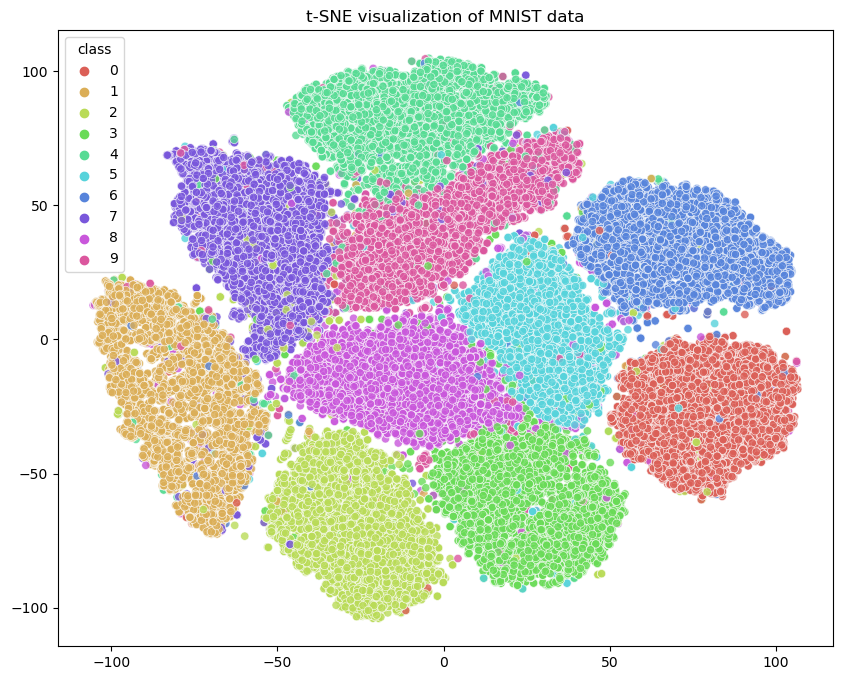

In [15]:
# 使用 t-SNE 进行降维
tsne = manifold.TSNE(n_components=2, random_state=42, perplexity=25)
transformed_data = tsne.fit_transform(pixel_array)

# 创建 DataFrame
tsne_df = pd.DataFrame(np.column_stack((transformed_data, targets)),
                       columns=["x", "y", "targets"])
tsne_df.loc[:, "targets"] = tsne_df.targets.astype(int)

# 可视化降维后的数据
def visualize_tsne(X, y):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=sns.color_palette("hls", 10), legend="full", alpha=0.8)
    plt.title('t-SNE visualization of MNIST data')
    plt.show()

visualize_tsne(transformed_data, targets)

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# 根据您的要求划分训练集和测试集
X_train = transformed_data[:60000]
y_train = targets[:60000]
X_test = transformed_data[60000:]
y_test = targets[60000:]

# 使用 KNN 算法
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# 对测试集进行预测
y_pred = knn.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Classification Accuracy: {accuracy}")

KNN Classification Accuracy: 0.9716


In [17]:
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from scipy.spatial.distance import cdist

# 执行 Parzen 窗口密度估计的函数

def parzen_window_estimation_optimized(X_train, X_test, h):
    # 计算所有测试样本和所有训练样本之间的距离
    distances = cdist(X_test, X_train, 'euclidean')
    # 计算 Parzen 窗口
    kernel_values = np.exp(-0.5 * (distances / h) ** 2) / (np.sqrt(2 * np.pi) * h)
    # 求每个测试样本的平均密度
    return kernel_values.mean(axis=1)

# 根据 Parzen 窗口估计进行分类的函数
def classify_parzen_window(X_train, y_train, X_test, h):
    unique_classes = np.unique(y_train)
    predictions = np.zeros(X_test.shape[0])
    for class_val in unique_classes:
        # 对每个类应用 Parzen 窗口估计
        class_mask = y_train == class_val
        pdf_estimates = parzen_window_estimation_optimized(X_train[class_mask], X_test, h)
        # 假设类别概率相等，取似然度最大值
        if class_val == 0 or pdf_estimates > predictions:
            predictions = pdf_estimates
            predicted_class = class_val
    return predicted_class

In [19]:
# 为 Parzen 窗口设置带宽参数
h = 0.42813323987193935 # 这是在一次失败的实验中得到的最佳参数，其实0.5左右的参数效果差不多。 

predictions = []
n_test_samples = len(X_test)
print_interval = 1000  # 每处理1000张图片打印一次进度
print(n_test_samples)

10000


In [20]:
for i in range(n_test_samples):
    prediction = classify_parzen_window(X_train, y_train, X_test[i].reshape(1, -1), h)
    predictions.append(prediction)

    # 每处理1000张图片时打印进度
    if (i + 1) % print_interval == 0 or i == n_test_samples - 1:
        print(f"已处理 {i + 1} / {n_test_samples} 张图片")

predictions = np.array(predictions)

已处理 1000 / 10000 张图片
已处理 2000 / 10000 张图片
已处理 3000 / 10000 张图片
已处理 4000 / 10000 张图片
已处理 5000 / 10000 张图片
已处理 6000 / 10000 张图片
已处理 7000 / 10000 张图片
已处理 8000 / 10000 张图片
已处理 9000 / 10000 张图片
已处理 10000 / 10000 张图片


In [21]:
# 计算准确率
accuracy = accuracy_score(y_test, predictions)
print(f'准确率: {accuracy}')

准确率: 0.9726
